In [1]:
from src.custom_embeddings import bge_m3_embed, qwen2_embed, nomic_embed
from src.vectorstorage import EmbeddingVectorStorage

In [2]:
# BAAI_bge_m3_RecursiveCharacterTextSplitter
# Alibaba-NLP_gte-Qwen2-7B_RecursiveCharacterTextSplitter
# nomic-ai_nomic-embed-text-v1_5_RecursiveCharacterTextSplitter

collection_name = "BAAI_bge_m3_RecursiveCharacterTextSplitter" 
path_persistent = "./data/chroma"

# Reload the vector store
bge_m3_vectordb = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection=collection_name,
    path_persistent=path_persistent
)

print(bge_m3_vectordb.test_heartbeat())  # Check if the Chroma client is active
print(bge_m3_vectordb.collection_is_empty())  # Check if the collection is empty

1732096241266874000
False


In [3]:
from langchain.chains import RetrievalQA
from langchain_ollama import OllamaLLM

qwen2_5_7B = 'qwen2.5:7b-instruct-q4_0'
qwen2_5_0_5B = 'qwen2.5:0.5b-instruct-q4_0'
qwen2_5_14B = 'qwen2.5:14b-instruct-q4_0'
qwen2_5_3B = 'qwen2.5:3b-instruct-q4_0'

basic_retriever = bge_m3_vectordb.as_retriever()
local_llm_model = OllamaLLM(model=qwen2_5_3B)

In [4]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from dotenv import load_dotenv

load_dotenv()

# https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/
# prompt: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=2d6cd9b7-5b49-44db-a523-a13c23f12f29
basic_prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | basic_prompt
    | local_llm_model
    | StrOutputParser()
)

basic_rag_chain = RunnableParallel(
    {"context": basic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

basic_rag_chain.invoke("The company is also aiming to reduce gas flaring?")

{'context': [Document(metadata={'date': '2021-12-13', 'domain': 'naturalgasintel', 'origin_doc_id': '955ad75cdc5396c0057252d76df2c445', 'title': 'ExxonMobil Envisions Carbon-Neutral Permian Operations by 2030', 'url': 'https://www.naturalgasintel.com/exxonmobil-envisions-carbon-neutral-permian-operations-by-2030/'}, page_content='their natural gas prices off of NGI s Mexico Gas Price Index. Read the analysis of our fifth survey of active players in Mexico, showcasing market driven insights now. , The company plans to electrify its operations with low carbon power, which may include wind, solar, hydrogen, natural gas with carbon capture and storage, or other emerging technologies, the firm said. ExxonMobil plans to expand its methane detection programs utilizing satellite surveillance and a network of ground based sensors for continuous monitoring, and aerial flyovers that identify leaks for rapid repairs. , By the end of this year, ExxonMobil plans to reduce flaring volumes across its 

In [5]:
from langchain_openai import ChatOpenAI
from src.evaluation import RAGEvaluation

# Initialize the class
openai_llm_model = ChatOpenAI(model="gpt-4o-mini")

In [6]:
evaluator = RAGEvaluation(
    name="Baseline",
    rag_chain=basic_rag_chain,
    llm_model=openai_llm_model,
    embeddings=bge_m3_embed
)

clean_file_path='data/preprocessed/clean_cleantech.parquet'
eval_file_path='data/eval_dataset/cleantech_rag_evaluation_data_2024-09-20.csv'

# Perform evaluation
results = evaluator.evaluate(clean_file_path, eval_file_path)

Loading cached data from: data/cache/BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


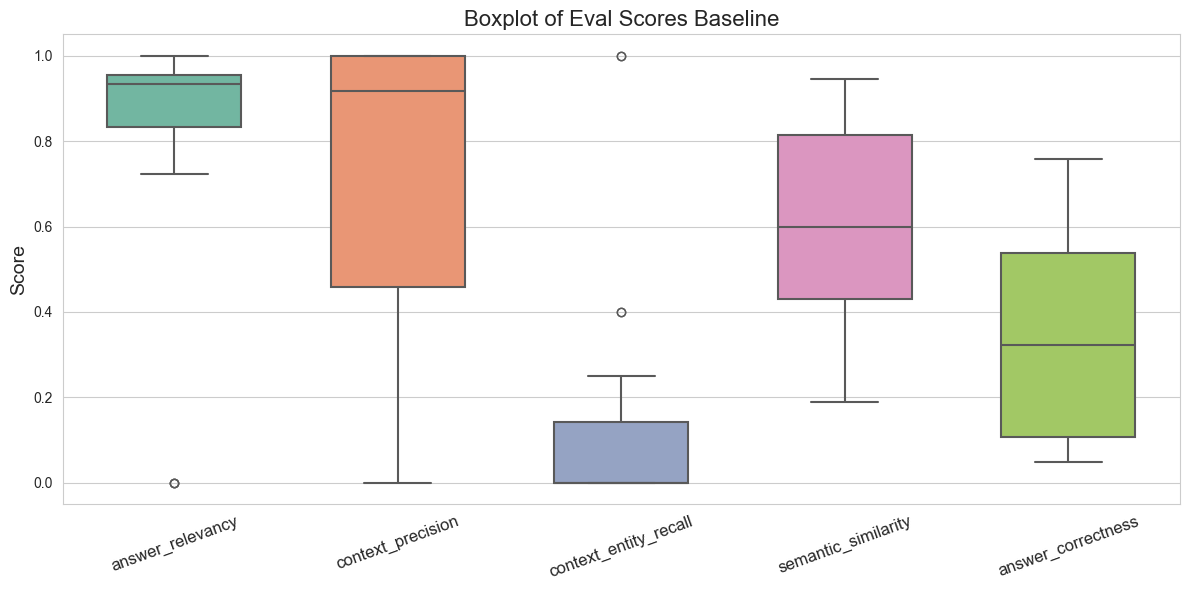

In [7]:
# Plot results directly from the DataFrame
evaluator.plot_eval_result(results)